# 11 Propensity Score

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from causalinference import CausalModel

import graphviz as gr

%matplotlib inline

# style.use("fivethirtyeight")
# pd.set_option("display.max_columns", 6)

In [2]:
data = pd.read_csv("./data/learning_mindset.csv")
data.sample(5, random_state=5)

,schoolid,intervention,achievement_score,success_expect,ethnicity,gender,frst_in_family,school_urbanicity,school_mindset,school_achievement,school_ethnic_minority,school_poverty,school_size
259,73,1,1.480828,5,1,2,0,1,-0.462945,0.652608,-0.515202,-0.169849,0.173954
3435,76,0,-0.987277,5,13,1,1,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
9963,4,0,-0.152340,5,2,2,1,0,-2.289636,0.190797,0.875012,-0.724801,0.761781
4488,67,0,0.358336,6,14,1,0,4,-1.115337,1.053089,0.315755,0.054586,1.862187
2637,16,1,1.360920,6,4,1,0,1,-0.538975,1.433826,-0.033161,-0.982274,1.591641


- 위의 데이터는 growth mindset을 가진 자들이 더 성공한다라는 가설을 검증하려고 한 것이다.
- 위의 데이터는 confounder가 있다.
- 일단 growth mindset이라는 `intervention`(treatment)은 이와 관련한 세미나를 수강하면 treatment를 받았다고 했다. 하지만 평소에 좀 더 진취적인 학생들이 해당 세미나를 신청하는 경향이 존재한다. (아래의 groupby 결과를 보자)
- 그렇다면 positively biased되었다고 예상해볼 수 있다.

In [3]:
data.groupby("success_expect")["intervention"].mean()

success_expect
1    0.271739
2    0.265957
3    0.294118
4    0.271617
5    0.311070
6    0.354287
7    0.362319
Name: intervention, dtype: float64

- 먼저 가장 기본적인 평균의 차이를 알아보자.

In [4]:
smf.ols("achievement_score ~ intervention", data=data).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.1538,0.012,-13.201,0.000,-0.177,-0.131
intervention,0.4723,0.020,23.133,0.000,0.432,0.512


- 위에서 두 집단은 `achievement_score`이 평균적으로 0.4723만큼 차이가 난다.

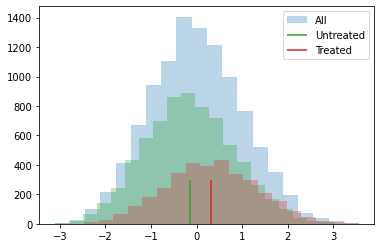

In [11]:
plt.hist(data["achievement_score"], bins=20, alpha=0.3, label="All")
plt.hist(data.query("intervention==0")["achievement_score"], bins=20, alpha=0.3, color="C2")
plt.hist(data.query("intervention==1")["achievement_score"], bins=20, alpha=0.3, color="C3")
plt.vlines(-0.1538, 0, 300, label="Untreated", color="C2")
plt.vlines(-0.1538+0.4723, 0, 300, label="Treated", color="C3")
plt.legend();

## Propensity Score

- propensity score: $P(T=1|X=x)$
- 원래 이전까지 우리는 conditional independence $Y_1, Y_0 \perp T | X$ 를 위해서 직적 confounders $X$를 control했다. 하지만 propensity score를 이용하여 그럴 필요가 없다.
- propensity score만 conditioning해도 된다. (증명됨)

$$(Y_1, Y_0) \perp T | P(x)$$

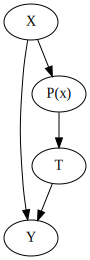

In [13]:
g = gr.Digraph()
g.edge("T", "Y")
g.edge("X", "Y")
g.edge("X", "P(x)")
g.edge("P(x)", "T")
g

## Propensity Weighting

$$E[Y|X,T=1]−E[Y|X,T=0] = E\bigg[\dfrac{Y}{P(x)}|X,T=1\bigg]P(x) - E\bigg[\dfrac{Y}{(1-P(x))}|X,T=0\bigg](1-P(x)) \\ = E\bigg[Y \dfrac{T-P(x)}{P(x)(1-P(x))}\bigg]$$

- 위의 estimator를 inverse probability of treatment weighting이라고 한다.
- $P(x)$는 treatment일 확률이다. treatment일 확률이 작으면 더 해당하는 outcome에 대한 weight가 커진다. 이런 식으로 pseudo population을 만드는 것이다.
- 분모에 $P(x)$, $1 - P(x)$가 들어가기 때문에 둘 다 0이상의 값을 가져야 한다.
  - 이는 causal inference에서 positivity assumption이라고 한다.
  - 이는 treated and untreated distribution이 overlap되야한다는 것을 의미하기도 한다.

## Propensity Score Estimation

- 우리는 true propensity score를 모르기 때문에 이를 추정한다.
- 주로 Logistic regression을 사용하는데 다른 ML모델을 사용해도 상관없다.

In [14]:
categ = ["ethnicity", "gender", "school_urbanicity"]
cont = ["school_mindset", "school_achievement", "school_ethnic_minority", "school_poverty", "school_size"]

data_with_categ = pd.concat([
    data.drop(columns=categ), # dataset without the categorical features
    pd.get_dummies(data[categ], columns=categ, drop_first=False)# categorical features converted to dummies
], axis=1)

print(data_with_categ.shape)

(10391, 32)


In [15]:
from sklearn.linear_model import LogisticRegression

T = 'intervention'
Y = 'achievement_score'
X = data_with_categ.columns.drop(['schoolid', T, Y])

ps_model = LogisticRegression(C=1e6).fit(data_with_categ[X], data_with_categ[T])

data_ps = data.assign(propensity_score=ps_model.predict_proba(data_with_categ[X])[:, 1])

data_ps[["intervention", "achievement_score", "propensity_score"]].head()

,intervention,achievement_score,propensity_score
0,1,0.277359,0.315494
1,1,-0.449646,0.263775
2,1,0.769703,0.344046
3,1,-0.121763,0.344046
4,1,1.526147,0.367797


- 이제 ps score를 이용하여 weight를 구하자.

In [16]:
weight_t = 1/data_ps.query("intervention==1")["propensity_score"]
weight_nt = 1/(1-data_ps.query("intervention==0")["propensity_score"])
print("Original Sample Size", data.shape[0])
print("Treated Population Sample Size", sum(weight_t))
print("Untreated Population Sample Size", sum(weight_nt))

Original Sample Size 10391
Treated Population Sample Size 10388.481047737421
Untreated Population Sample Size 10391.479498429853


- ps score로 confounding의 증거를 찾을수도 있다.

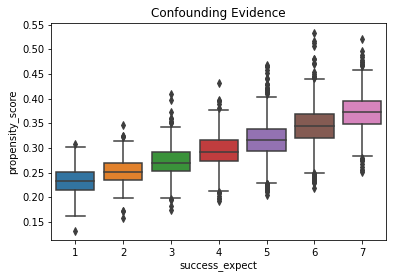

In [17]:
sns.boxplot(x="success_expect", y="propensity_score", data=data_ps)
plt.title("Confounding Evidence");

- overlap도 확인해보자
  - 0, 1에 가까운 값도 없고
  - 거의 다 겹친다

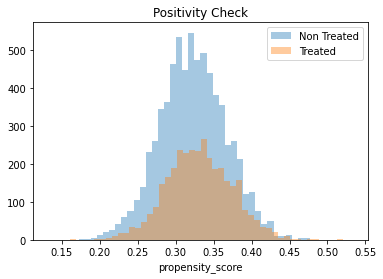

In [18]:
sns.distplot(data_ps.query("intervention==0")["propensity_score"], kde=False, label="Non Treated")
sns.distplot(data_ps.query("intervention==1")["propensity_score"], kde=False, label="Treated")
plt.title("Positivity Check")
plt.legend();

- ps score로 ATE를 구해보자

In [19]:
weight = ((data_ps["intervention"]-data_ps["propensity_score"]) /
          (data_ps["propensity_score"]*(1-data_ps["propensity_score"])))

y1 = sum(data_ps.query("intervention==1")["achievement_score"]*weight_t) / len(data)
y0 = sum(data_ps.query("intervention==0")["achievement_score"]*weight_nt) / len(data)

ate = np.mean(weight * data_ps["achievement_score"])

print("Y1:", y1)
print("Y0:", y0)
print("ATE", np.mean(weight * data_ps["achievement_score"]))

Y1: 0.2595915097146309
Y0: -0.12892941796262494
ATE 0.38852092767725543


## Standard Error

- IPTW estimator의 standard error를 아래와 같이 구할 수 있다.

$$\sigma^2_w = \dfrac{\sum_{i=1}^{n}w_i(y_i-\hat{\mu})^2}{\sum_{i=1}^{n}w_i}$$

- 하지만 이는 true ps score를 알아야하고 우리는 대신 estimated ps score를 사용한다. 따라서 이로 인해 발생하는 error가 존재하고 이를 위의 수식대로 구하기 어렵다.
- 그렇다면 bootstrapping을 이용해보자.
  - sampling with replacement

In [ ]:
from joblib import Parallel, delayed # for parallel processing

# define function that computes the IPTW estimator
def run_ps(df, X, T, y):
    # estimate the propensity score
    ps = LogisticRegression(C=1e6).fit(df[X], df[T]).predict_proba(df[X])[:, 1]
    
    weight = (df[T]-ps) / (ps*(1-ps)) # define the weights
    return np.mean(weight * df[y]) # compute the ATE

np.random.seed(88)
# run 1000 bootstrap samples
bootstrap_sample = 1000
ates = Parallel(n_jobs=4)(delayed(run_ps)(data_with_categ.sample(frac=1, replace=True), X, T, Y)
                          for _ in range(bootstrap_sample))
ates = np.array(ates)

In [21]:
print(f"ATE: {ates.mean()}")
print(f"95% C.I.: {(np.percentile(ates, 2.5), np.percentile(ates, 97.5))}")

ATE: 0.3877469718369056
95% C.I.: (0.354515037976982, 0.41992762520764715)


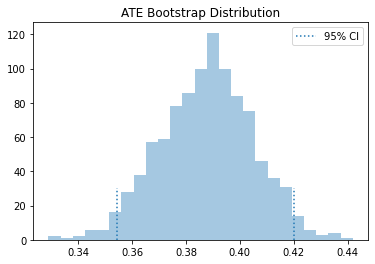

In [22]:
sns.distplot(ates, kde=False)
plt.vlines(np.percentile(ates, 2.5), 0, 30, linestyles="dotted")
plt.vlines(np.percentile(ates, 97.5), 0, 30, linestyles="dotted", label="95% CI")
plt.title("ATE Bootstrap Distribution")
plt.legend();

## Common issue with ps score

- ps score를 정확하게 예측하는 것이 balancing properites를 의미하는 것은 아니다.
- Propensity score doesn’t need to predict the treatment very well. It just needs to include all the confounding variables.
- treatment를 예측하기 좋은 variable이지만 outcome과 관련이 없다면 ps score estimator의 variance를 증가시킬 뿐이다.


- 아래의 데이터를 통해 이해해보자.
  - 2개의 학교
  - 둘 중 하나는 99%가 세미나를 들었고 다른 학교는 1%가 들었다.
  - 학교는 outcome에 영향이 없다고 (가정)한다.
  - 따라서 `school`을 ps score 예측에 사용하면 예측력이 좋다.
  - 하지만 ps score가 극단적으로 나오게 되고 이 때문에 variance가 엄청 커진다.

In [24]:
np.random.seed(42)
school_a = pd.DataFrame(dict(T=np.random.binomial(1, .99, 400), school=0, intercept=1))
school_b = pd.DataFrame(dict(T=np.random.binomial(1, .01, 400), school=1, intercept=1))
ex_data = pd.concat([school_a, school_b]).assign(y = lambda d: np.random.normal(1 + 0.1 * d["T"]))
ex_data.head()

,T,school,intercept,y
0,1,0,1,0.309526
1,1,0,1,1.571468
2,1,0,1,2.982024
3,1,0,1,2.445420
4,1,0,1,2.693187


In [25]:
ate_w_f = np.array([run_ps(ex_data.sample(frac=1, replace=True), ["school"], "T", "y") for _ in range(500)])
ate_wo_f = np.array([run_ps(ex_data.sample(frac=1, replace=True), ["intercept"], "T", "y") for _ in range(500)])

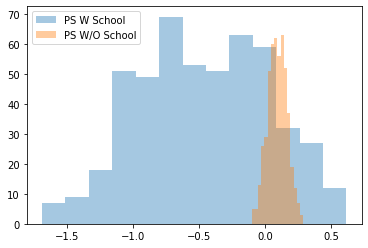

In [26]:
sns.distplot(ate_w_f, kde=False, label="PS W School")
sns.distplot(ate_wo_f, kde=False, label="PS W/O School")
plt.legend();

- 위 그림에서 알 수 있듯이 ATE의 variance가 엄청 커졌다.
- need to construct the prediction in a way that controls for confounding, not in a way to predict the treatment!

- 이전에 살펴본 데이터는 상당히 balanced 되어 있었지만 아래의 그림처럼 그렇지 않은 경우도 많이 존재한다.

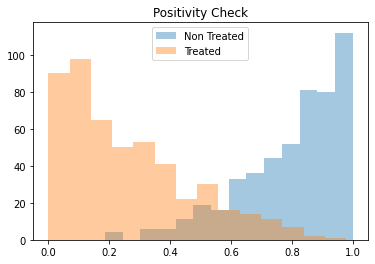

In [27]:
sns.distplot(np.random.beta(4,1,500), kde=False, label="Non Treated")
sns.distplot(np.random.beta(1,3,500), kde=False, label="Treated")
plt.title("Positivity Check")
plt.legend();

- 위와 같은 경우 (weak positivity, lack of balancing)
  - can generate some bias
  - 왜냐면 unknown region에 대해 treatment effect에 대해 extrapolate해야되기 때문이다.
  - 주로 weight가 20이상이면 문제가 발생할 수 있다.
- 이를 약간 보완하기 위해
  - weight의 max를 20으로 제한하는 방법이 있다.
  - 이는 variance를 줄이지만 bias는 더 커지게 한다.
- overlap이 너무 약하다면 causal한 접근이 적절하지 않을 수 있다.

## Propensity Score Matching

- $X$가 아니라 ps score를 control하는 것으로 충분하다.
- 차원축소 같은 것으로 생각할 수도 있다.
- 따라서 이를 regression model에 넣어보자.
  - ATE가 0.39로 나왔다.

In [29]:
smf.ols("achievement_score ~ intervention + propensity_score", data=data_ps).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-3.0765,0.065,-47.051,0.000,-3.205,-2.948
intervention,0.3930,0.019,20.974,0.000,0.356,0.430
propensity_score,9.0537,0.200,45.304,0.000,8.662,9.445


- 그렇다면 우리는 ps score를 matching에서도 사용할 수 있다.

In [30]:
cm = CausalModel(
    Y=data_ps["achievement_score"].values, 
    D=data_ps["intervention"].values, 
    X=data_ps[["propensity_score"]].values
)

cm.est_via_matching(matches=1, bias_adj=True)

print(cm.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.395      0.025     15.908      0.000      0.347      0.444
           ATC      0.388      0.027     14.240      0.000      0.335      0.442
           ATT      0.410      0.027     15.427      0.000      0.357      0.462



- 하지만 위에 나온 SE는 정확하지 않다. true ps score가 아닌 추정값을 사용하는 것을 고려하지 않았기 때문이다. 그래서 bootstrap을 하려고 했으나 할 수 없다고 한다.
  - [ON THE FAILURE OF THE BOOTSTRAP FOR MATCHING ESTIMATORS](https://economics.mit.edu/files/11862)